In [1]:
%matplotlib notebook
#%matplotlib inline
# standard imports 
from __future__ import division 
from __future__ import print_function 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from glob import glob 
from sunpy.net import Fido, attrs
from datetime import datetime, timedelta
import astropy.units as u 
import sunpy.map as smap 
from astropy.coordinates import SkyCoord 
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel
from datetime import datetime, timedelta
import matplotlib.dates as mdates 
import pickle

In [2]:
from AIA_tools import * 

In [3]:
pickles = glob('./*.pickle')
print(pickles) 
pickles = {'boxInfo':pickles[0], 'intensities':pickles[1], 'times':pickles[2]}
print(pickles)

['./boxInfo_MaEtAl.pickle', './intensities_MaEtAl.pickle', './times_MaEtAl.pickle']
{'intensities': './intensities_MaEtAl.pickle', 'boxInfo': './boxInfo_MaEtAl.pickle', 'times': './times_MaEtAl.pickle'}


In [4]:
data = {'boxInfo':None, 'intensities':None, 'times':None}    

for key in data: 
    print(key) 
    file_ = open(pickles[key], 'r') 
    data[key] = pickle.load(file_ ) 

    


intensities
boxInfo
times


** get array of time steps and then create a time axis in seconds ** 

In [5]:
times = {'171':[], '193':[], '211':[], '304':[], '335':[]}

for key in times:
    # start the times at zero seconds and add that to the list 
    tot = 0.0
    times[key].append(tot)
    
    # get difference and add to tot 
    for i in range(1, len(data['times'][key])): 
        t_diffs =(data['times'][key][i]-data['times'][key][i-1]).total_seconds()
        tot += t_diffs
        times[key].append(tot) 

In [6]:
print(times['171'])

[0.0, 12.01, 23.990000000000002, 36.02, 48.0, 60.01, 71.99, 84.02, 95.99, 108.00999999999999, 119.99, 132.01, 143.98999999999998, 156.01999999999998, 167.98999999999998, 180.01, 192.0, 204.02, 215.99, 228.02, 239.99, 252.01000000000002, 264.0, 276.02, 288.0, 300.01, 311.99, 324.02, 335.99, 348.01, 359.99, 372.01, 383.99, 396.01, 408.0, 420.01, 431.99, 444.02, 455.99, 468.01, 480.0, 492.01, 504.0, 516.02, 527.99, 540.01, 551.99, 564.02, 575.99, 588.01, 599.99, 612.01, 623.99, 636.02, 647.99, 660.01, 671.99, 684.02, 695.99, 708.01, 719.99, 732.01, 743.99, 756.02, 767.99, 780.01, 791.99, 804.02, 815.99, 828.01, 839.99, 852.01, 864.0, 876.02, 887.99, 900.01, 912.0, 924.02, 935.99, 948.02, 960.0, 972.01, 983.99, 996.02, 1007.99, 1020.01, 1031.99, 1044.02, 1055.99, 1068.02, 1080.0, 1092.01, 1103.99, 1116.02, 1127.99, 1140.01, 1151.99, 1164.02, 1175.99, 1188.02]


** Plot the observational data ** 

<IPython.core.display.Javascript object>


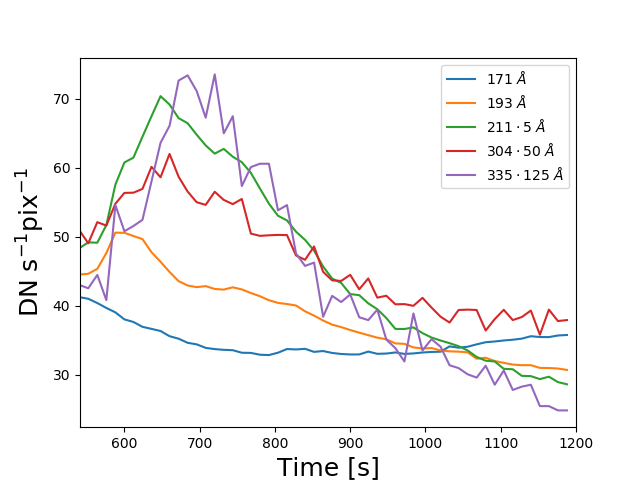

In [14]:
intensities = data['intensities']

fig, ax = plt.subplots() 

ax.plot(times['171'], intensities['171'], label='$171$ $\AA$') 
ax.plot(times['193'], intensities['193'], label='$193$ $\AA$')
ax.plot(times['211'], 5*np.asarray(intensities['211']), label='$211 \cdot 5$ $\AA$')
ax.plot(times['304'], 50*np.asarray(intensities['304']), label='$304 \cdot 50$ $\AA$')
ax.plot(times['335'], 125*np.asarray(intensities['335']), label='$335 \cdot 125$ $\AA$') 
ax.set_ylabel("DN $\mathrm{s}^{-1} \mathrm{pix}^{-1}$", fontsize=18)
ax.set_xlabel("Time [s]", fontsize=18)
ax.set_xlim(541, 1200) 
ax.legend() 

** Now take ratios and plot -- FIXME -- ask how to deal with times for ratio plots (interpolation?) ** 

<IPython.core.display.Javascript object>


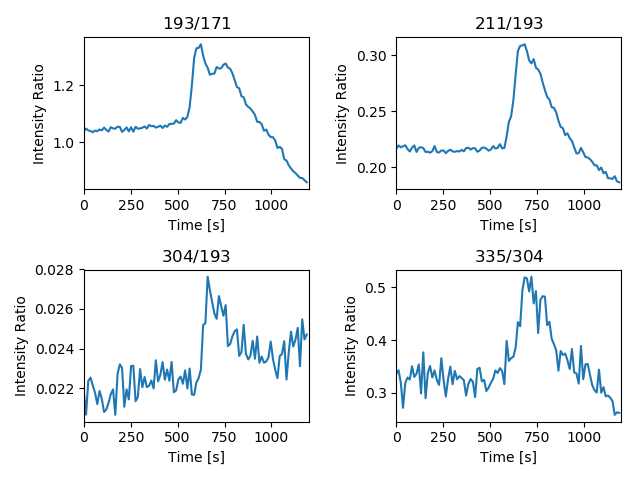

In [15]:
intensities = data['intensities']

fig, ax = plt.subplots(nrows=2, ncols=2) 

ax[0,0].plot(np.mean([times['193'], times['171']], axis=0),
             np.divide(intensities['193'],intensities['171']), label='$193/171$') 
ax[0,1].plot(np.mean([times['211'], times['193']], axis=0),
             np.divide(intensities['211'],intensities['193']), label='$211/193$')
ax[1,0].plot(np.mean([times['304'], times['193']], axis=0),
             np.divide(intensities['304'],intensities['193']), label='$304/193$')
ax[1,1].plot(np.mean([times['335'], times['304']], axis=0),
             np.divide(intensities['335'],intensities['304']), label='$335/304$') 

ax[0,0].set_ylabel("Intensity Ratio")
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_xlim(0, 1200)
ax[0,0].set_title('$193/171$')

ax[0,1].set_ylabel("Intensity Ratio")
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_xlim(0, 1200)
ax[0,1].set_title('$211/193$')

ax[1,0].set_ylabel("Intensity Ratio")
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_xlim(0, 1200)
ax[1,0].set_title('$304/193$')

ax[1,1].set_ylabel("Intensity Ratio")
ax[1,1].set_xlabel("Time [s]")
ax[1,1].set_xlim(0, 1200)
ax[1,1].set_title('$335/304$')

plt.tight_layout()
plt.show()


** Now let's try to run a simulation ** 

In [16]:
# trying out temperature from Ma et al. paper 
te_sta = 1e6 
te_end = 2.8e6 
n = 1e7

element_list = '2, 6, 7, 8, 10, 12, 13, 14, 16, 18, 20, 26, 28'  # He, C, N, O, Ne, Mg, Al, Si, S, Ar, Ca, Fe, Ni
simDataFile = simulation.run(te_sta, te_end, n, num=13,
               indices=element_list, ntime=10, dt=0.75, filename='te_end-1e6__te_sta-2.8e6__n-1e7.dat')

** Now load in the data ** 

In [17]:
simData = simulation.getSimulationData(simDataFile)
print(np.shape(simData['fractions']))
print(np.shape(simData['times']))

(12, 30, 30)
(11,)


** So it looks like indexing is [time, element, ion]. Now lets grab the emissivities.** 

In [18]:
pathToChiantiEmiss = '/data/khnum/REU2018/jwaczak/data/chiantiEmissData'
emissFiles = simulation.getEmissList(pathToChiantiEmiss)

** Figure out how to loop through our triple dictionary ** 

for key in emissFiles.keys():
    for key2 in emissFiles[key].keys(): 
        for key3 in emissFiles[key][key2].keys(): 
            print(key, key2, key3, emissFiles[key][key2][key3])

** Yay the file lookup dictionary worked! Test plotting for simulation output for one element at one time.** 

In [99]:
obs_times = simData['times']
print(obs_times) 

[0.0, 0.75, 1.5, 2.25, 3.0, 3.75, 4.5, 5.25, 6.0, 6.75, 7.5]


fig, ax = plt.subplots() 
plt.yscale("log")
plt.ylim(1.0e-5, 1.0)



** load in the AIA response sav file and abundance files ** 

In [42]:
from scipy.io import readsav 

eff_area = readsav('/data/khnum/REU2018/jwaczak/data/June_2010_CME_burst/aia_response/eff_area.sav')
aia_channels = ['A94', 'A131', 'A171', 'A193', 'A211', 'A304', 'A335']

log10_abund = {} 
pathToAbund = '/data/khnum/REU2018/jwaczak/data/CHIANTI_8.0.7_database/abundance/sun_coronal_1992_feldman.abund'
with open(pathToAbund, 'r') as f: 
    for line in f: 
        splitline = line.split(' ')
        lineData = [] 
        for thing in splitline: 
            if not (thing is ''): 
                lineData.append(thing) 
        if lineData[0] == '-1\n': 
            break
        else:
            log10_abund.update({lineData[0]: float(lineData[1])})
                    
print(log10_abund)

{'11': 6.93, '10': 8.08, '13': 7.04, '12': 8.15, '20': 6.93, '14': 8.1, '16': 7.27, '18': 6.58, '28': 6.84, '26': 8.1, '1': 12.0, '2': 10.9, '7': 8.0, '6': 8.59, '8': 8.89}


In [47]:
# now get actual abundance 
abund = {} 
for key in log10_abund.keys(): 
    abund.update({key: np.power(10.0,(log10_abund[key]-12))})
    
print(abund)
print(len(abund))

{'11': 8.51138038202376e-06, '10': 0.00012022644346174131, '13': 1.0964781961431852e-05, '12': 0.00014125375446227554, '20': 8.51138038202376e-06, '14': 0.0001258925411794166, '16': 1.8620871366628657e-05, '18': 3.801893963205613e-06, '28': 6.9183097091893625e-06, '26': 0.0001258925411794166, '1': 1.0, '2': 0.07943282347242822, '7': 0.0001, '6': 0.0003890451449942805, '8': 0.0007762471166286928}
15


** Let's open one of these emissivity files to see what's going on ** 

<IPython.core.display.Javascript object>


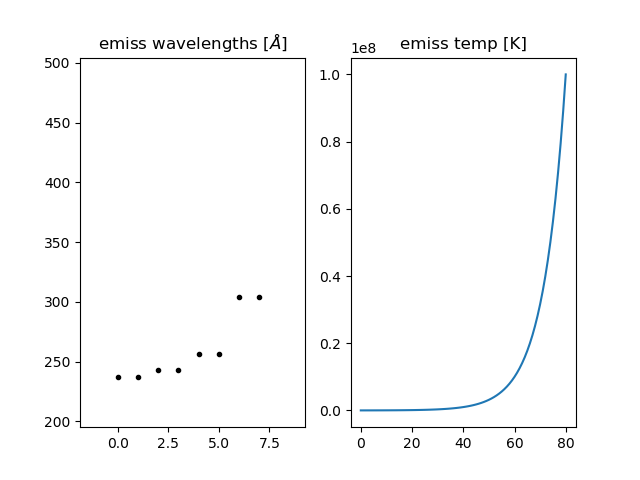

Nearest temperature to te_end is:2818381.69348
10126.793 237.331


In [87]:
testEmiss = simulation.getEmissData(emissFiles[2][2][7])
em_2d = testEmiss['em_2d']
wavelengths = testEmiss['lambda_1d']
log_temps = testEmiss['logte_1d']
temps = np.power(10.0, log_temps) 
fig, ax = plt.subplots(nrows=1, ncols=2) 
ax[0].plot(wavelengths, 'k.')
ax[0].set_title('emiss wavelengths [$\AA$]')
ax[1].plot(temps) 
ax[1].set_title('emiss temp [K]')


print("Nearest temperature to te_end is:{}".format(temps[analysis.getNearestValue(temps, te_end)]))
print(wavelengths.max(), wavelengths.min())

** Now lets loop through and create the synthetic observation ** 

In [123]:
observation = {'times':obs_times, '171':np.zeros(len(obs_times)), '193':np.zeros(len(obs_times)),
               '211':np.zeros(len(obs_times)), '304':np.zeros(len(obs_times)), '335':np.zeros(len(obs_times))}
elem_list = [2, 6, 7, 8, 10, 12, 13, 14, 16, 18, 20, 26, 28] 

# loop through each time 
for i in range(len(observation['times'])):
    print(i) 
    
    
    # get the nei fractions for specified time 
    nei_fracs = simData['fractions'][i]
    
    # loop through each simulated element 
    for elem in elem_list: 
        print('\t', elem) 
            
        ion_fracs = nei_fracs[elem-1,:] # indices start at 0
     
        # loop through all ions for that element 
        for j in range(max(elem_list)+1): 
            if (j in emissFiles[elem].keys()):  # tables don't have all possible ions 
                # look up emissivity data
                emissData = simulation.getEmissData(emissFiles[elem][j][7])
                emiss_wavelengths = emissData['lambda_1d']
                emiss_log_temps = emissData['logte_1d']
                
                
                # get nearest temperature index
                temp_index = analysis.getNearestValue(np.power(10.0, emiss_log_temps), te_end)
                
                # find min and max allowed values for interpolation  #(25,900) is range for response wavelegnths
                #wavelength_max = analysis.getNearestValue(emiss_wavelengths, 900)
                #wavelength_min = analysis.getNearestValue(emiss_wavelengths, 25)
                #while(emiss_wavelengths[wavelength_max] > 900): 
                #    wavelength_max = wavelength_max - 1
                #while (emiss_wavelengths[wavelength_min] < 25): 
                #    wavelength_min = wavelength_min + 1 
                
                wav_indices = np.asarray(range(len(emiss_wavelengths)))
                wav_indices = wav_indices[(emiss_wavelengths[wav_indices]<=900) & (emiss_wavelengths[wav_indices]>=25)]
                
                emiss_wavelengths = emiss_wavelengths[wav_indices]
                emiss0 = emissData['em_2d'][wav_indices, temp_index]
                emiss0 = emiss0*ion_fracs[j]*abund[str(elem)]
                
                # loop through new channels to get synthetic counts
                for channel in aia_channels: 
                    if channel.replace('A', '') in observation.keys(): # we aren't using all of the AIA channels in response function 
                        ea_data = eff_area['effarea'][channel][0]
                        ea_wavelengths = ea_data['wave'][0]
                        ea_values = ea_data['ea'][0]
                    
                        # interpolate to match emissivity wavelengths
                        # interp1d returns interpolation function that will interpolate 
                        # to a given vector of values 
                        interp_obj = interp1d(ea_wavelengths, ea_values,kind='quadratic')
                    
                        
                        try:
                            interp_ea = interp_obj(emiss_wavelengths)
                        except: 
                            print(elem, j, np.max(emiss_wavelengths), np.max(ea_wavelengths), '\t', np.min(emiss_wavelengths), np.min(ea_wavelengths)) 
                        
                        
                        # now make the new emissivity with the AIA response included 
                        em_new = interp_ea*emiss0
                    
                        # sum up all of the 'counts' to get total number for that band 
                        em_tot = np.sum(em_new)
                        
                        # add this to the appropriate index in observation dictionary 
                        observation[channel.replace('A','')][i] = observation[channel.replace('A','')][i]+em_tot
 


0
	 2
	 6
	 7
	 8
	 10
	 12
	 13
	 14
	 16
	 18
	 20
	 26


KeyboardInterrupt: 